# Oscillatory model: Augment by 0/1 vs. Time labels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, gaussian_kde
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [4]:
# Dataset 1 (n_missing = 15)
param_prior_1 = np.array([[0.2, -0.4]])
result_1 = [
    np.array(
        [
            -0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
             0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
            -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
            -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
            -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
             0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
            -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
            -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
            -0.34380109,
        ]
    ),
    np.array(
        [
            0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
            27, 28, 29, 30, 31, 33, 36, 37, 39,
        ]
    ),
     np.array(
         [
             0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
             4.  , 4.25, 4.75, 5.  , 6.  , 6.25,
             6.75, 7.  , 7.25, 7.5 , 7.75,
             8.25, 9.  , 9.25, 9.75,
         ],
     ),
]

# Dataset 2 (n_missing = 20)
param_prior_2 = np.array([[0.95, 0.1]])
result_2 = [
    np.array(
        [
             0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
             1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
             0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
            -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
            -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
            -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
             0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
             0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
             0.07219064,
        ]
    ),
    np.array(
        [
            1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
            33, 36, 37, 38,
        ],
    ),
    np.array(
        [
            0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
            5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5,
        ],
    ),
]

param_priors = [param_prior_1, param_prior_2]
results = [result_1, result_2]

In [5]:
n_post_samples = 7500

# Augment by 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_augment01,
    checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', 
    skip_checks=True,
)

# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_timelabels = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_timelabels,
    checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', 
    skip_checks=True,
)

amortizers = {"augment01": amortizer_augment01, "timelabels": amortizer_timelabels}

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


In [6]:
# Encode missing data
x_datas = []
for result in results:
    x_datas.append({})

    x_data = np.ones((1, n_obs, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-5.0, 0.0])
    x_datas[-1]["augment01"] = x_data
    
    n_present = len(result[1])
    x_data = np.ones((1, n_present, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0][result[1]]
    x_data[0, :, 1] = result[2]
    x_datas[-1]["timelabels"] = x_data

In [7]:
# Sample from BayesFlow
samples = []
for result_ix, result in enumerate(results):
    samples.append({})
    for amortizer_id, amortizer in amortizers.items():
        x_data = x_datas[result_ix][amortizer_id]
        samples[-1][amortizer_id] = amortizer.sample(x_data, n_post_samples)

In [8]:
# Calculate integration boundaries
bounds = []
for dct in samples:
    param_samples = dct["augment01"]
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]       
    std_x = np.sqrt(cov_sample[0, 0])
    std_y = np.sqrt(cov_sample[1, 1])
    lb_x = mean_x - 6*std_x
    ub_x = mean_x + 6*std_x
    lb_y = mean_y - 6*std_y
    ub_y = mean_y + 6*std_y
    bounds.append([(lb_x, ub_x), (lb_y, ub_y)])

## Posterior plot

In [9]:
# Calculate analytical posteriors

def get_posterior(result, bounds):
    [(lb_x, ub_x), (lb_y, ub_y)] = bounds

    def prior_eval(a,b):
        # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
        if a > 0.1 and a < 1.0:
            return 1/0.9 * norm.pdf(b, 0.0, 0.25)
        else: 
            return 0.

    def likelihood(a,b):   
        # Calculates likelihood of available data
        residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(a,b):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(a,b) * prior_eval(a,b)

    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, lb_y, ub_y, lambda y: lb_x, lambda y: ub_x)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for result_ix, result in enumerate(results):
    posteriors.append({})
    for amortizer_id, param_samples in samples[result_ix].items():
        _bounds = bounds[result_ix]
        posteriors[-1][amortizer_id] = get_posterior(result, _bounds)

In [10]:
cmap = "viridis"
amortizer_labels = {"augment01": "Augment by $0/1$", "timelabels": "Time labels"}

def plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix, levels=None):
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    # Level sets of analytic posterior distribution
    grid = 201
    A = np.linspace(xmin, xmax, grid)
    if amortizer_id=="timelabels" and result_ix==1:
        A = np.linspace(0.948, 0.952, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy])   
    _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)

    ax.set_xlabel('Parameter $a$')
    ax.set_ylabel('Parameter $b$')
    ax.set_title(amortizer_labels[amortizer_id])

## Posterior predictive check

In [17]:
# Posterior predictive check
time_line = np.linspace(0, 10, 501)

def plot_predictive_check(ax, param_prior, result, param_samples, n_sim=1000):
    
    traj_sim = np.empty((n_sim, len(time_line)))
    
    for k in range(n_sim):
        a = param_samples[k, 0]   # frequency
        b = param_samples[k, 1]   # shift    
        traj_sim[k] = np.sin(a*2*np.pi*time_line) + b
    
    traj_mean = np.mean(traj_sim, axis=0)
    ax.plot(time_line, traj_mean, color='orange', label='Simulated mean')
    ax.fill_between(time_line, traj_mean-3*sigma, traj_mean+3*sigma, color='orange', alpha=.25, label='$3\sigma$ CI')
    
    a = param_prior[0, 0]   # frequency
    b = param_prior[0, 1]   # shift
    ax.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='black', linestyle="dashed", label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', markersize=4.25, label='Available data')
    ax.set_title(amortizer_labels[amortizer_id])
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

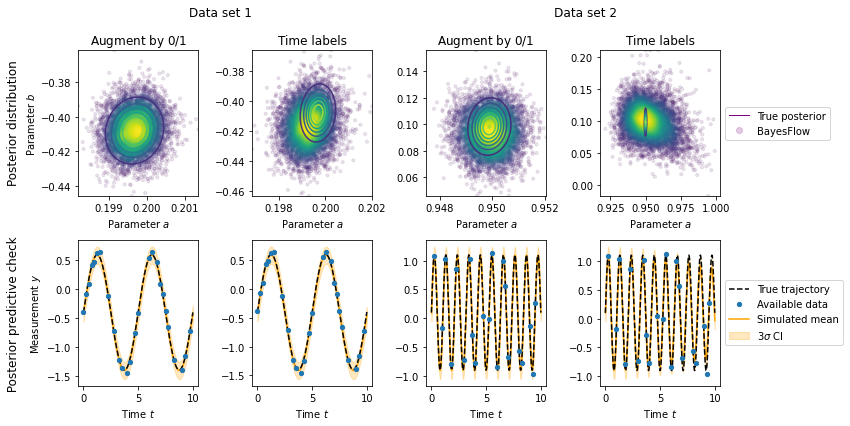

In [18]:
fig, axes_all = plt.subplots(2, 4, figsize=(12, 6))

axes = axes_all[0, :]
for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
            
# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

axes = axes_all[1, :]
for result_ix, (param_prior, result) in enumerate(zip(param_priors, results)):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        param_samples = samples[result_ix][amortizer_id]
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_predictive_check(ax, param_prior, result, param_samples)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
        ax.set_title(None)

# Legend
handles, labels = axes[-1].get_legend_handles_labels()
order = [2,3,0,1]
axes[-1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1,0.5))


fig.suptitle("Data set 1                                                                              Data set 2          ")
fig.supylabel(" Posterior predictive check             Posterior distribution       ")

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_augment_time_CI.{fmt}", dpi=300, bbox_inches='tight')